In [1]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

In [9]:
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

# Dictionary that maps class names to IDs
''' 
The classes include palstic which is trash, bio which refers to biological 
life and rov which is remotely operated vehicles
'''
class_name_to_id_mapping = {"plastic": 0,
                           "rov": 1,
                           "bio": 2,}

### Convert to yolo format

In [33]:
# Convert the info dict to the required yolo format and write it to disk
yolo_loc = "/Users/praksj/Documents/VIT/Year-3/sem 6/video analytics/Jcomp/data/trash_icra_xml/yolo_labels"
def convert_to_yolov5(info_dict, folder):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join(yolo_loc,folder, info_dict["filename"].replace("jpg", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [34]:
xml_file = "/Users/praksj/Documents/VIT/Year-3/sem 6/video analytics/Jcomp/data/trash_icra_xml/labels/train/bio0012_frame0000073.xml"
da = extract_info_from_xml(xml_file)
convert_to_yolov5(da, "train")

In [35]:
print(da)

{'bboxes': [{'class': 'bio', 'xmin': 107, 'xmax': 229, 'ymin': 41, 'ymax': 343}], 'filename': 'bio0012_frame0000073.jpg', 'image_size': (480, 360, 3)}


### Sanity check

In [13]:
class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()



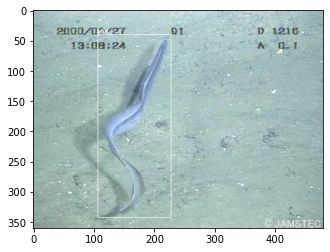

In [23]:
annotation_file = "/Users/praksj/Documents/VIT/Year-3/sem 6/video analytics/Jcomp/Notebooks/annotations/bio0012_frame0000073.txt"
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]
image_file = "/Users/praksj/Documents/VIT/Year-3/sem 6/video analytics/Jcomp/data/trash_icra_xml/images/train/bio0012_frame0000073.jpg"
assert os.path.exists(image_file)
#Load the image
image = Image.open(image_file)
plot_bounding_box(image, annotation_list)

## Converting xml files to yolov5 directorywise


In [36]:
base_loc = "/Users/praksj/Documents/VIT/Year-3/sem 6/video analytics/Jcomp/data/trash_icra_xml/labels"
test = os.path.join(base_loc, "test")
train = os.path.join(base_loc, "train")
valid = os.path.join(base_loc, "valid")

for file in os.scandir(train) :
    name = file.name
    xml_file = os.path.join(train, name)
    data = extract_info_from_xml(xml_file)
    convert_to_yolov5(data, "train")
print("train directory converted")

for file in os.scandir(valid) :
    name = file.name
    xml_file = os.path.join(valid, name)
    data = extract_info_from_xml(xml_file)
    convert_to_yolov5(data, "valid")
print("valid directory converted")

for file in os.scandir(test) :
    name = file.name
    xml_file = os.path.join(test, name)
    data = extract_info_from_xml(xml_file)
    convert_to_yolov5(data, "test")
print("test directory converted")


train directory converted
valid directory converted
test directory converted


### Reference
https://blog.paperspace.com/train-yolov5-custom-data/

https://www.kaggle.com/datasets/sovitrath/underwater-trash-detection-icra
